## Does Seawater "Feel" Warmer in Fall Than in Summer Along the Oregon Coast?
A friend of mine (M) was talking about going surfing today. I was surprised, because I thought the seawater would be colder than it was a few weeks ago (Aug-Sep). Another friend (K) mentioned that this might be due to the delayed response of seawater to solar heating. M also said she had heard from others that seawater is often warmer during this time of year (Oct-Nov) than in summer.

However, I argued that what we actually feel might be due to the temperature difference between the water and the air. In summer, the seawater is typically colder than the air, so we feel cold when we get into the water. In contrast, in the fall, the seawater can be warmer than the air, so when we get into the water, it feels warm.

To figure out what is really happening, I downloaded 20 years (2005–2024) of meteorological/oceanographic data from the National Data Buoy Center (NOAA) for a coastal site near Port Orford, OR. The dataset includes both near-surface air temperature and sea surface temperature, which I used to analyze how these temperatures vary throughout the seasons.

### Python packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import calendar

from pathlib import Path
from scipy.stats import t

### Functions

In [2]:
def c2f(c):  # °C -> °F
    return c * 9/5 + 32

def f2c(f):  # °F -> °C
    return (f - 32) * 5/9

### Data
- Data center:   National Buoy Data Center, NOAA
- Station:       PORO3-9431647, Port Orford, OR
- Owned:         NOAA's National Ocean Service
- Location:      42.739 N 124.498 W (42°44'20" N 124°29'53" W)
- Time:          2005-2024 (historical)
- Website:       https://www.ndbc.noaa.gov/station_page.php?station=PORO3
- Format:        txt file

In [3]:
basedir = "/Users/huang/Data/Buoy/PORO3"
files = sorted(Path(basedir).glob("US_west_PORO3_*.txt"))

na_vals = [99, 99.0, 99.00, 999, 999.0, 999.00, 9999, 9999.0, 9999.00]

# read each file, keep first header row, skip the units row
dfs = [
    pd.read_csv(
        f,
        sep=r"\s+",
        header=0,
        skiprows=[1],
        na_values=na_vals,
        engine="python",
    ).assign(source_file=f.name)  # optional: keep provenance
    for f in files
]

# combine
df = pd.concat(dfs, axis=0, ignore_index=True)

# (if needed) normalize any stray spaces in column names
df.columns = df.columns.str.strip()

# build timestamp
y = df["YY"].astype(int)
year = y.where(y >= 100, 2000 + y)
dt = pd.to_datetime(
    dict(year=year, month=df["MM"], day=df["DD"], hour=df["hh"], minute=df["mm"]),
    errors="coerce",
    utc=True,
)

# set index and drop time-part columns
df = df.set_index(dt).drop(columns=["YY", "MM", "DD", "hh", "mm"])
df.index.name = "time"

# tidy: sort chronologically and drop duplicate timestamps if they exist
df = df.sort_index()
df = df[~df.index.duplicated(keep="first")]

# Convert UTC -> local first (America/Los_Angeles for PORO3)
df = df.tz_convert("America/Los_Angeles")

df


,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE,source_file
time,,,,,,,,,,,,,,
2005-03-31 18:00:00-08:00,209.0,6.1,7.2,NaN,NaN,NaN,NaN,1023.4,11.6,12.7,NaN,NaN,NaN,US_west_PORO3_2005.txt
2005-03-31 19:00:00-08:00,201.0,6.2,8.1,NaN,NaN,NaN,NaN,1023.2,11.6,12.4,NaN,NaN,NaN,US_west_PORO3_2005.txt
2005-03-31 20:00:00-08:00,202.0,7.0,9.4,NaN,NaN,NaN,NaN,1023.7,11.6,12.3,NaN,NaN,NaN,US_west_PORO3_2005.txt
2005-03-31 21:00:00-08:00,198.0,7.9,10.5,NaN,NaN,NaN,NaN,1023.8,11.6,12.3,NaN,NaN,NaN,US_west_PORO3_2005.txt
2005-03-31 22:00:00-08:00,196.0,8.4,11.9,NaN,NaN,NaN,NaN,1023.7,11.4,12.6,NaN,NaN,NaN,US_west_PORO3_2005.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 15:30:00-08:00,170.0,8.6,11.2,NaN,NaN,NaN,NaN,1021.0,8.7,10.7,NaN,NaN,NaN,US_west_PORO3_2024.txt
2024-12-31 15:36:00-08:00,171.0,6.8,10.2,NaN,NaN,NaN,NaN,1020.9,NaN,NaN,NaN,NaN,NaN,US_west_PORO3_2024.txt
2024-12-31 15:42:00-08:00,169.0,8.4,11.7,NaN,NaN,NaN,NaN,1020.8,NaN,NaN,NaN,NaN,NaN,US_west_PORO3_2024.txt


### Variables
- ATMP: 8 m above site elevation
- WTMP: 1.3 m below MLLW (Mean Lower Low Water)

In [4]:
# Clean variables (keep your >50°C filter)
atmp = df["ATMP"].where(df["ATMP"] <= 50, np.nan)
sst  = df["WTMP"]

### (A) Annual cycles of air and sea surface temperatures

In [5]:
# Daily means on the full calendar (this will include Feb 29 where applicable)
daily = pd.DataFrame({"ATMP": atmp, "WTMP": sst}).resample("D").mean(numeric_only=True)

# Year and month-day keys
daily["year"] = daily.index.year
daily["mmdd"] = daily.index.strftime("%m-%d")

# Build a leap-year template order (2000 is a leap year)
template = pd.date_range("2000-01-01", "2000-12-31", freq="D")
mmdd_order = template.strftime("%m-%d")  # length 366; includes "02-29"

# Pivot to year × MM-DD, then reindex columns to leap-year template
atmp_2d = (daily.pivot(index="year", columns="mmdd", values="ATMP")
                 .reindex(columns=mmdd_order))
sst_2d  = (daily.pivot(index="year", columns="mmdd", values="WTMP")
                 .reindex(columns=mmdd_order))

# Daily climatology (column-wise mean). "02-29" uses only leap years automatically.
atmp_clim = atmp_2d.mean(axis=0, skipna=True)  # index: MM-DD (366)
sst_clim  = sst_2d.mean(axis=0,  skipna=True)

# --- 95% CI with Student-t (per day, across years) ---
# counts of non-NaN years per day
n_at  = atmp_2d.count(axis=0).astype(float)
n_sst = sst_2d.count(axis=0).astype(float)

# sample std across years (per day)
std_at  = atmp_2d.std(axis=0, ddof=1)
std_sst = sst_2d.std(axis=0, ddof=1)

# standard error
se_at  = std_at / np.sqrt(n_at)
se_sst = std_sst / np.sqrt(n_sst)

# degrees of freedom
df_at  = n_at  - 1
df_sst = n_sst - 1

# t critical values for 95% CI (two-sided); NaN where df < 1
t_at  = pd.Series(np.nan, index=df_at.index)
t_sst = pd.Series(np.nan, index=df_sst.index)
mask_at  = df_at  >= 1
mask_sst = df_sst >= 1
t_at.loc[mask_at]   = t.ppf(0.975, df_at.loc[mask_at])
t_sst.loc[mask_sst] = t.ppf(0.975, df_sst.loc[mask_sst])

# confidence half-widths
ci_at  = t_at  * se_at
ci_sst = t_sst * se_sst

### Figure 1

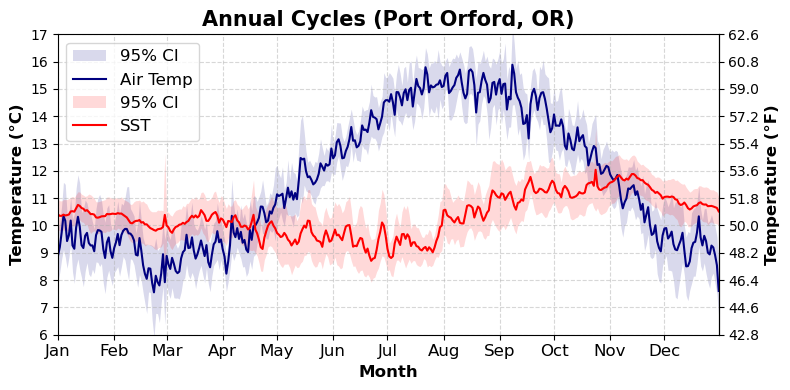

In [6]:
x = np.arange(1, len(template) + 1)

fig, ax = plt.subplots(figsize=(8, 4))

# 95% CI bands
ax.fill_between(x, (atmp_clim - ci_at).values, (atmp_clim + ci_at).values,
                color='navy', alpha=0.15, linewidth=0, label="95% CI")
ax.plot(x, atmp_clim.values, color='navy', label="Air Temp")

ax.fill_between(x, (sst_clim - ci_sst).values, (sst_clim + ci_sst).values,
                color='red',  alpha=0.15, linewidth=0, label="95% CI")

ax.plot(x,  sst_clim.values, color='red',  label="SST")

ax.set_xlim(1, 366)
ax.set_ylim(6, 17)

# Put ticks at month starts and label them Jan, Feb, ...
month_starts = template[template.day == 1]
xticks  = month_starts.dayofyear
xlabels = month_starts.strftime("%b")
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, fontsize=12)

ax.set_yticks(np.arange(6, 18, 1))

ax.set_xlabel("Month", fontsize=12, fontweight="bold")
ax.set_ylabel("Temperature (°C)", fontsize=12, fontweight="bold")
ax.set_title("Annual Cycles (Port Orford, OR)", fontsize=15, fontweight="bold")
ax.legend(fontsize=12, loc="upper left")
ax.grid(True, linestyle="--", alpha=0.5)

# Force the right y-axis ticks to line up with the left
plt.draw()  # ensure left ticks are finalized
left_ticks_c = ax.get_yticks()                 # tick positions in °C
right_ticks_f = c2f(left_ticks_c)              # convert to °F

secax = ax.secondary_yaxis('right', functions=(c2f, f2c))
secax.set_ylabel("Temperature (°F)", fontsize=12, fontweight="bold")
secax.set_yticks(right_ticks_f)                # align positions
# Cleaner integer-ish °F labels
secax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

plt.tight_layout()
plt.show()

From the 20-year averaged in-situ observational data (Fig. 1), we can see that the air temperature (8 m above sea level) exhibits a strong annual cycle, with its peak occurring in boreal summer (late July to early September) and its lowest values in boreal winter/spring (mid-February to early March). The sea surface temperature (SST, measured 1.3 m below mean lower low water) also shows an annual cycle, but with a weaker amplitude. Its peak occurs in boreal fall (late October to early November), and its lowest values occur in boreal summer (late June to late July).

An interesting point to note is that the air temperature begins to drop below the SST around the first week of November. This indicates that cold air outbreaks from higher latitudes begin to strongly influence mid-latitude regions (e.g., the Pacific Northwest), likely associated with the seasonal southward shift and meandering of the jet stream. Meanwhile, the SST remains relatively warm, possibly due to the delayed response of the ocean to solar heating. Ocean surface currents may also play a role in modulating SST along the coast. For example, the California Current and northerly winds along the U.S. West Coast can enhance coastal upwelling via Ekman transport, bringing cold, deeper water to the surface and cooling SST. It is possible that during late summer, northerly winds are weaker than in spring or early summer, resulting in weaker upwelling compared to fall. However, this requires further investigation.

From Figure 1 alone, we can conclude that SST is indeed warmer in the fall than in the summer. We can also see that starting in the first week of November, the air temperature becomes lower than the SST.

### (2) Diurnal cycles of air and sea surface temperatures

In [7]:
# Hourly cadence in LOCAL time
hourly = df.resample("H").mean(numeric_only=True)

# Keys for grouping (LOCAL calendar)
hourly["mmdd"] = hourly.index.strftime("%m-%d")
hourly["hour"] = hourly.index.hour

# Leap-year template (LOCAL tz just for clarity)
template = pd.date_range("2000-01-01", "2000-12-31", freq="D", tz="America/Los_Angeles")
mmdd_order = template.strftime("%m-%d")

# Group by (MM-DD, hour) and mean across years
atmp_dc = hourly.groupby(["mmdd", "hour"])["ATMP"].mean().unstack("hour")
sst_dc  = hourly.groupby(["mmdd", "hour"])["WTMP"].mean().unstack("hour")

# Reindex to leap-year order (366 rows; cols 0..23)
atmp_dc = atmp_dc.reindex(mmdd_order)
sst_dc  = sst_dc.reindex(mmdd_order)

# Monthly mean diurnal cycle climatology
atmp_dc_monavg = atmp_dc.groupby(atmp_dc.index.str[:2]).mean()
sst_dc_monavg  = sst_dc.groupby(sst_dc.index.str[:2]).mean()

# month keys '01'..'12' in calendar order
order = [f"{m:02d}" for m in range(1, 13)]

mon_lbl = {f"{m:02d}": calendar.month_abbr[m] for m in range(1, 13)}

In [8]:
# Add 95% Student-t confidence bands for the monthly mean diurnal cycle
hourly["year"]  = hourly.index.year
hourly["month"] = hourly.index.month  # 1..12

# Per (year, month, hour) means
atmp_y_m_h = hourly.groupby(["year", "month", "hour"])["ATMP"].mean().unstack("hour")
sst_y_m_h  = hourly.groupby(["year", "month", "hour"])["WTMP"].mean().unstack("hour")

# Interannual count, std, SE for each (month, hour)
n_at_mh   = atmp_y_m_h.groupby(level="month").count()
n_sst_mh  = sst_y_m_h.groupby(level="month").count()
std_at_mh = atmp_y_m_h.groupby(level="month").std(ddof=1)
std_sst_mh= sst_y_m_h.groupby(level="month").std(ddof=1)

se_at_mh  = std_at_mh / np.sqrt(n_at_mh)
se_sst_mh = std_sst_mh / np.sqrt(n_sst_mh)

# Student-t critical values per (month, hour)
df_at  = n_at_mh  - 1
df_sst = n_sst_mh - 1
t_at   = pd.DataFrame(np.where(df_at>=1,  t.ppf(0.975, df_at),  np.nan),
                      index=df_at.index,  columns=df_at.columns)
t_sst  = pd.DataFrame(np.where(df_sst>=1, t.ppf(0.975, df_sst), np.nan),
                      index=df_sst.index, columns=df_sst.columns)

# 95% CI half-widths per (month, hour)
ci_at_mh  = t_at  * se_at_mh   # shape (12, 24), index=1..12 months, columns=0..23 hours
ci_sst_mh = t_sst * se_sst_mh

### Figure 2

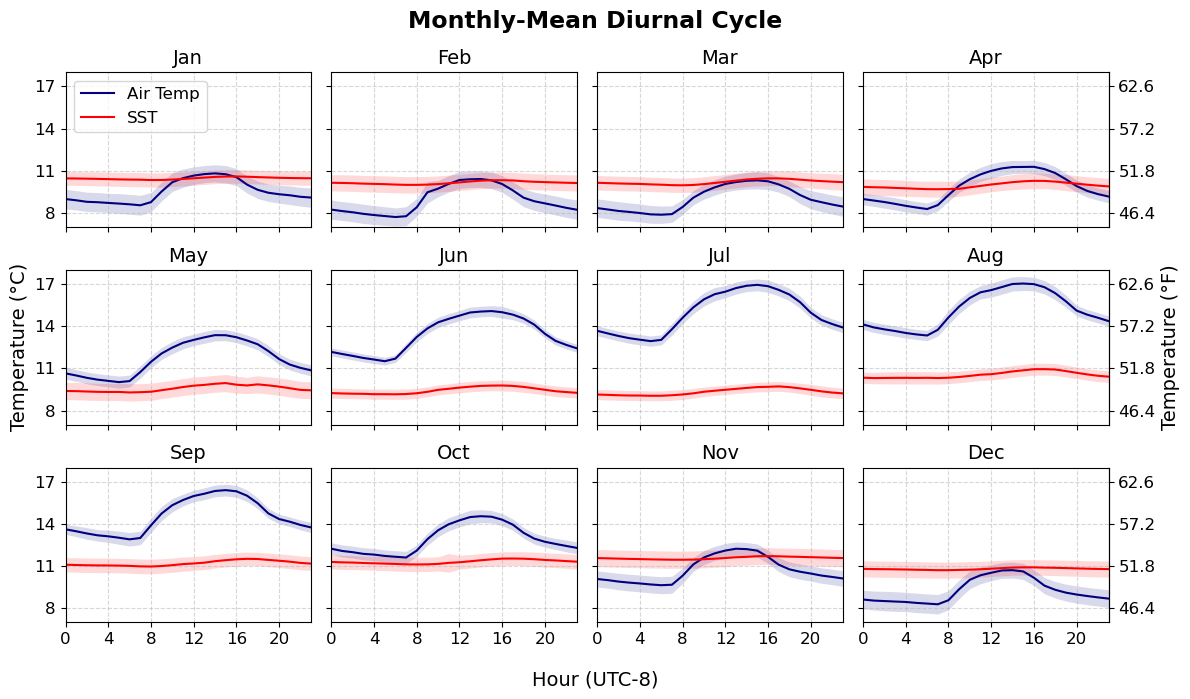

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(12, 7), sharex=True, sharey=True)
axes = axes.ravel()

for i, m in enumerate(order):
    ax = axes[i]
    if m in atmp_dc_monavg.index:  # guard in case some months are missing
        mi = int(m)  # month number 1..12
        hrs = atmp_dc_monavg.columns.astype(float)

        # --- 95% Student-t CI bands (draw first) ---
        ax.fill_between(hrs,
                        (atmp_dc_monavg.loc[m] - ci_at_mh.loc[mi]).values,
                        (atmp_dc_monavg.loc[m] + ci_at_mh.loc[mi]).values,
                        color='navy', alpha=0.15, linewidth=0, label="_nolegend_")
        ax.fill_between(hrs,
                        (sst_dc_monavg.loc[m] - ci_sst_mh.loc[mi]).values,
                        (sst_dc_monavg.loc[m] + ci_sst_mh.loc[mi]).values,
                        color='red',  alpha=0.15, linewidth=0, label="_nolegend_")
        # --- Mean diurnal cycles ---
        ax.plot(atmp_dc_monavg.columns, atmp_dc_monavg.loc[m], color='navy', label="Air Temp")
        ax.plot(sst_dc_monavg.columns,  sst_dc_monavg.loc[m], color='red',  label="SST")
        
    ax.set_title(mon_lbl[m], fontsize=14)
    ax.set_xticks(np.arange(0, 24, 4))
    ax.set_yticks(np.arange(8, 22, 3))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlim(0, 23)
    ax.set_ylim(7, 18)
    ax.grid(linestyle="--", alpha=0.5)

axes[0].legend(loc="upper left", fontsize=12)

for ax in axes[-4:]:
    ax.set_xlabel("")
fig.supxlabel("Hour (UTC-8)", fontsize=14)

axes[4].set_ylabel("Temperature (°C)", fontsize=14)

# Add °F on right y-axis ONLY for the rightmost column subplots
right_col_idx = [3, 7, 11]  # 0-based indices for a 3x4 grid
for idx in right_col_idx:
    ax = axes[idx]
    # create secondary y-axis that is functionally linked to °C axis
    secax = ax.secondary_yaxis('right', functions=(c2f, f2c))
    secax.tick_params(axis='both', which='major', labelsize=12)
    if idx == 7:
        secax.set_ylabel("Temperature (°F)", fontsize=14)
        
    # make ticks align exactly with the left y-ticks
    plt.draw()  # ensure left ticks are finalized
    left_ticks_c = ax.get_yticks()
    secax.set_yticks(c2f(left_ticks_c))

plt.suptitle("Monthly-Mean Diurnal Cycle", fontsize=17, fontweight="bold")
plt.tight_layout()
plt.show()

Examining the diurnal cycles of both air and sea surface temperatures (Fig. 2), we see that the air temperature has a stronger diurnal variation, with a peak occurring around 3 PM, whereas the SST shows a much weaker diurnal cycle and peaks later, around 5 PM.

From December to March, the air temperature is almost always lower than the SST except around midday. This suggests that if people go surfing during this time of year, the water may actually feel warmer than the air, depending on the time of day they go.

Looking at October and November, we observe a noticeable drop in air temperature, from approximately 12–15°C (54–59°F) down to about 10–12°C (50–53°F). In contrast, the SST slightly increases, from roughly 11.5°C (52.7°F) to around 12°C (53.6°F). However, in August and September, the air temperature is consistently much higher than the SST. This further confirms that although SST is indeed higher in November than in late summer, the primary factor influencing how warm or cold the water feels is the decrease in air temperature, rather than a large change in SST.

### Conclusion & Discussion

So, I guess both of our arguments are correct. The SST does reach its peak during late October to early November (Fig. 1), but it is only about 1–2°C (1.8–3.6°F) warmer than in August and September. In contrast, the air temperature drops substantially from August to November (Fig. 1). Moreover, in November, the air temperature is only slightly higher than the SST, by about 1°C (1.8°F), and only for a few hours around noon (Fig. 2).

Another point to consider is that our perception of temperature does not always match the actual measured values. Factors such as air humidity and wind speed also influence how warm or cold we feel, since latent heat (evaporation and condensation) plays a role in regulating body temperature.